In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, ImageDraw, ImageOps
import scipy.io as sio
import cv2
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import sys
import h5py
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
import scipy.io as sio
from scoreNet_fc import scoreNet

mat = sio.loadmat('/local_scratch/vsushko/AAnaconda/02-25 transfer from caffe/model/places_mean_resize.mat')['image_mean']

In [2]:
folder_root = '/local_scratch/vsushko/AAnaconda/xalameda/gazeability'
boxes_data_folder = '/local_scratch/vsushko/AAnaconda/xalameda/gazeability/yolo900results'
boxes_data_path ='/local_scratch/vsushko/AAnaconda/xalameda/gazeability/yolo900results/bounding_boxes_train_sorted.txt'
file_boxes = open(boxes_data_path, 'r')
def get_tensors(image, gaze, eyes, mat):   #image got by cv2.imread
    
    pic = image  
#--------------------------------------------------------
    alpha = 0.3
    w_x = int(np.floor(alpha*pic.shape[1]))
    w_y = int(np.floor(alpha*pic.shape[0]))
    if w_x%2 == 0:
        w_x += 1
    if w_y%2 == 0:
        w_y += 1
    im_face = np.zeros((pic.shape[0], pic.shape[1], 3), dtype='uint8')
    center = np.floor([gaze[0]*pic.shape[1], gaze[1]*pic.shape[0]]).astype(int)
    d_x = int(np.floor((w_x-1)/2))
    d_y = int(np.floor((w_y-1)/2))
    tmp = center[0]-d_x;
    img_l   = max(0, tmp);
    delta_l = max(0, -tmp);
    tmp = center[0]+d_x+1;
    img_r   = min(pic.shape[1], tmp);
    delta_r = w_x-(tmp-img_r);
    tmp = center[1]-d_y;
    img_t   = max(0, tmp);
    delta_t = max(0, -tmp);
    tmp = center[1]+d_y+1;
    img_b   = min(pic.shape[0], tmp);
    delta_b = w_y-(tmp-img_b);
    im_face[img_t:img_b,img_l:img_r,:] = pic[img_t:img_b,img_l:img_r,:]
    face_numpy = np.array(im_face)
    face_pic = Image.fromarray(face_numpy)
    obj = face_pic
#--------------------------------------------------------
    alpha = 0.3
    w_x = int(np.floor(alpha*pic.shape[1]))
    w_y = int(np.floor(alpha*pic.shape[0]))
    if w_x%2 == 0:
        w_x += 1
    if w_y%2 == 0:
        w_y += 1
    im_face = np.zeros((pic.shape[0], pic.shape[1], 3), dtype='uint8')
    center = np.floor([eyes[0]*pic.shape[1], eyes[1]*pic.shape[0]]).astype(int)
    d_x = int(np.floor((w_x-1)/2))
    d_y = int(np.floor((w_y-1)/2))
    tmp = center[0]-d_x;
    img_l   = max(0, tmp);
    delta_l = max(0, -tmp);
    tmp = center[0]+d_x+1;
    img_r   = min(pic.shape[1], tmp);
    delta_r = w_x-(tmp-img_r);
    tmp = center[1]-d_y;
    img_t   = max(0, tmp);
    delta_t = max(0, -tmp);
    tmp = center[1]+d_y+1;
    img_b   = min(pic.shape[0], tmp);
    delta_b = w_y-(tmp-img_b);
    im_face[img_t:img_b,img_l:img_r,:] = pic[img_t:img_b,img_l:img_r,:]
    face_numpy = np.array(im_face)
    face_pic = Image.fromarray(face_numpy)
    face = face_pic
#--------------------------------------------------------    
    image_mean_tmp = cv2.resize(mat, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
    image = image - image_mean_tmp

    image = np.transpose(image, (2, 0, 1))
    obj   = np.transpose(obj, (2, 0, 1))
    face  = np.transpose(face, (2, 0, 1))
    
    dim = image.shape
    image = torch.tensor(image).view(1, 3, dim[1], dim[2]).float()
    obj = torch.tensor(obj).view(1, 3, dim[1], dim[2]).float()
    face  = torch.tensor(face).view(1, 3, dim[1], dim[2]).float()
    
    return [image, obj, face]

def check_bounds(x1, x2, y1, y2, shape):
    xx1 = x1
    xx2 = x2
    yy1 = y1
    yy2 = y2
    if x1 < 0:
        xx1 = 0
    if x2 < 0:
        xx2 = 0
    if y1 < 0:
        yy1 = 0
    if y2 < 0:
        yy2 = 0
    if x1 > shape[0]:
        xx1 = shape[0]-1
    if x2 > shape[0]:
        xx2 = shape[0]-1
    if y1 > shape[1]:
        yy1 = shape[1]-1
    if y2 > shape[1]:
        yy2 = shape[1]-1
    return xx1, xx2, yy1, yy2

def gaze_in_bbox(gaze, x1, x2, y1, y2, shape):
    ans = True
    if not (gaze[1]*shape[0] >= x1 and gaze[1]*shape[0] <= x2):
        ans = False
    if not (gaze[0]*shape[1] >= y1 and gaze[0]*shape[1] <= y2):
        ans = False
    return ans


def gen_gauss(pic, eyes):
    x_grid, y_grid = np.meshgrid(np.linspace(1, pic.shape[1], pic.shape[1]), np.linspace(1,pic.shape[0], pic.shape[0]))
    sigma = 20
    mu = np.array([eyes[0]*pic.shape[1], eyes[1]*pic.shape[0]])
    d = np.sqrt((x_grid-mu[0])*(x_grid-mu[0])+(y_grid-mu[1])*(y_grid-mu[1]))
    g = np.exp(-( (d)**2 / ( 2.0 * sigma**2 ) ) )
    #g = 1*(d < 20)
    g = g/np.max(g)
    return g

# Testing of gazeability scores:

In [4]:
net_scores = scoreNet()
net_scores.load_state_dict(torch.load("right_fc_trained_model0-042.ptch", map_location='cpu'))



image:
score for positive object:  0.84321886
score for negative object:  0.0009008029


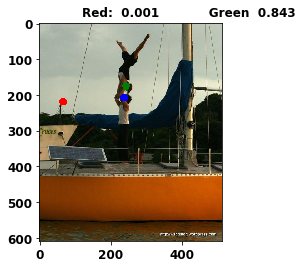

---
image:
score for positive object:  1.0
score for negative object:  4.7220816e-05


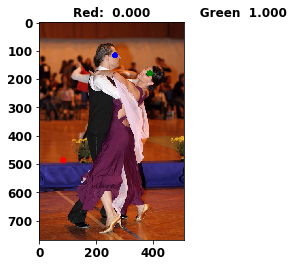

---
image:
score for positive object:  0.87388116
score for negative object:  0.0005310007


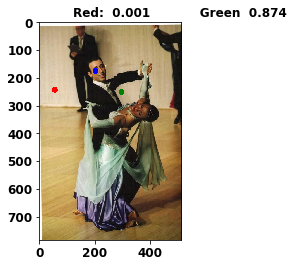

---
image:
score for positive object:  0.99999833
score for negative object:  0.0002352511


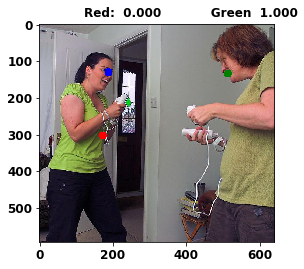

---
image:
score for positive object:  0.9876259
score for negative object:  0.29488453


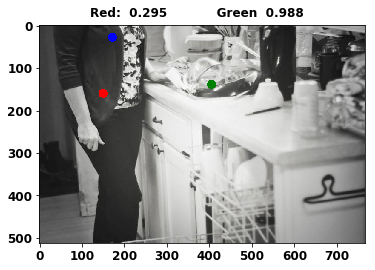

---
image:
score for positive object:  0.9468592
score for negative object:  0.47543913


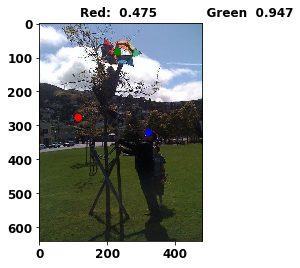

---
image:
score for positive object:  1.0
score for negative object:  0.00024706675


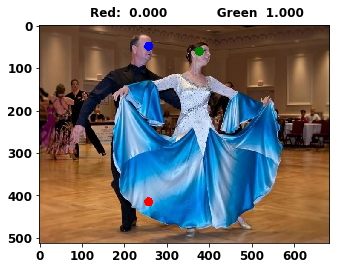

---
image:
score for positive object:  0.9837532
score for negative object:  0.00010815244


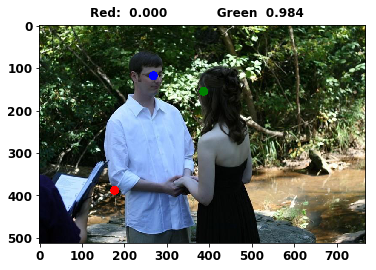

---
image:
score for positive object:  0.5942841
score for negative object:  0.99430037


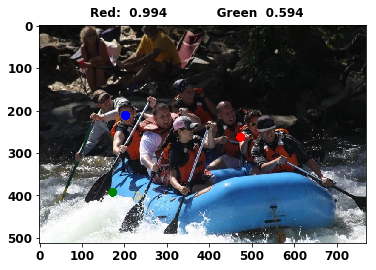

---
image:
score for positive object:  0.5693954
score for negative object:  0.00057729747


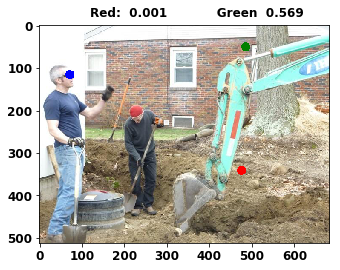

---
image:
score for positive object:  0.99998856
score for negative object:  0.0003029928


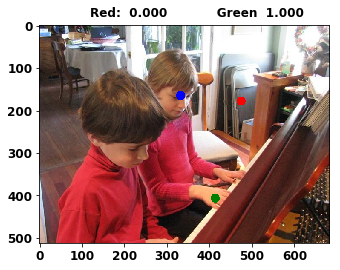

---
image:
score for positive object:  0.999102
score for negative object:  0.017402967


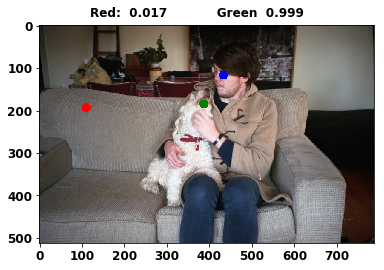

---
image:
score for positive object:  0.9999659
score for negative object:  0.025245277


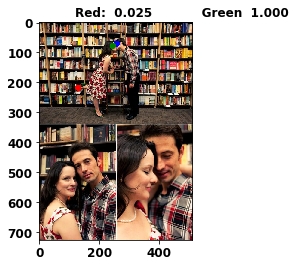

---
image:
score for positive object:  0.6692258
score for negative object:  0.037264362


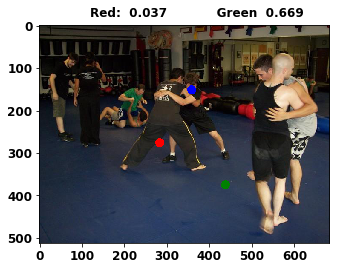

---
image:
score for positive object:  1.0
score for negative object:  3.643216e-05


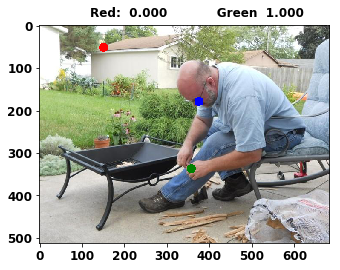

---
image:
score for positive object:  1.0
score for negative object:  0.41123


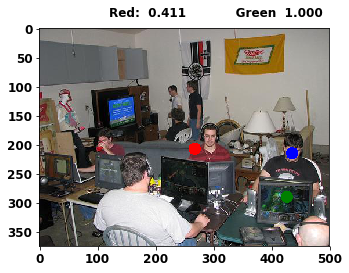

---
image:
score for positive object:  1.0
score for negative object:  0.03567837


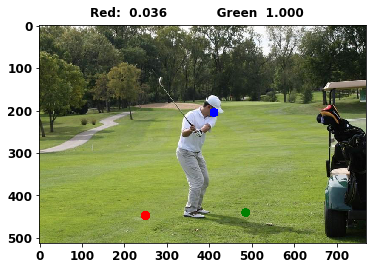

---
image:
score for positive object:  1.0
score for negative object:  0.003603603


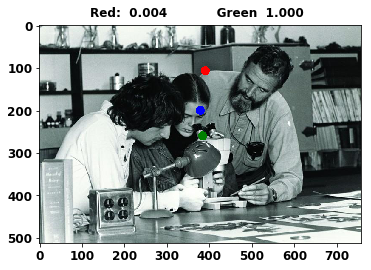

---
image:
score for positive object:  1.0
score for negative object:  0.00015658274


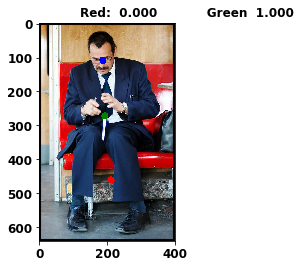

---
image:
score for positive object:  1.0
score for negative object:  0.0014720086


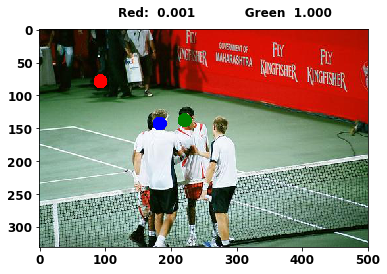

---
-----------------------------------------


In [11]:
# for train_annotation dont use idx < ~~1000!!
import warnings
warnings.filterwarnings("ignore")

description = pd.read_csv('/local_scratch/vsushko/AAnaconda/xalameda/gazeability/data/train_annotations.txt', header=None)
description_neg = pd.read_csv('centers_random.txt', header=None)
root_path = '/local_scratch/vsushko/AAnaconda/xalameda/gazeability/data/'
num_of_iter = 0
acc = 0

for idx in range(42900, 42920):
    img_path = description.iloc[idx, 0]
    gaze = (description.iloc[idx, 8], description.iloc[idx, 9])
    eyes = (description.iloc[idx, 6], description.iloc[idx, 7])
    neg_gaze = (description_neg.iloc[idx, 1], description_neg.iloc[idx, 2])
    image = cv2.imread(root_path+img_path)
    
    print("image:")
    
    
    ground_truth_neg = gen_gauss(image, neg_gaze)
    ground_truth_eyes = gen_gauss(image, eyes)
    ground_truth_gaze = gen_gauss(image, gaze)
    
    dim = image.shape
    ground_truth_eyes = torch.tensor(ground_truth_eyes).view(1, 1, dim[0], dim[1]).float()
    ground_truth_gaze = torch.tensor(ground_truth_gaze).view(1, 1, dim[0], dim[1]).float()
    ground_truth_neg  = torch.tensor(ground_truth_neg).view(1, 1, dim[0], dim[1]).float()
    image, obj, face = get_tensors(image, gaze, eyes, mat)

    output = net_scores(image, face, obj, ground_truth_gaze, ground_truth_eyes)
    score_green = output.detach().numpy()[0][1]
    print("score for positive object: ", score_green)
    

    obj_neg = cv2.imread('negative_random_object_pictures/'+str(idx+0)+'.jpg')
    obj_neg = np.array(obj_neg)
    obj_neg = np.transpose(obj_neg, (2, 0, 1))
    dim = obj_neg.shape
    obj_neg = torch.tensor(obj_neg).view(1, 3, dim[1], dim[2]).float()

    output = net_scores(image, face, obj_neg, ground_truth_neg, ground_truth_eyes)
    score_red = output.detach().numpy()[0][1]
    print("score for negative object: ", score_red)
    
    pic = Image.open(root_path+img_path)
    im = pic
    draw = ImageDraw.Draw(im) 
    #draw.line((eyes[0]* pic.size[0],eyes[1]* pic.size[1],
    #           y_predict, x_predict), fill=128, width=10)
    draw.ellipse((eyes[0]* pic.size[0]-10,eyes[1]* pic.size[1]-10, eyes[0]* pic.size[0]+10,eyes[1]* pic.size[1]+10), fill = 'blue', outline ='blue')
    draw.ellipse((gaze[0]* pic.size[0]-10,gaze[1]* pic.size[1]-10, gaze[0]* pic.size[0]+10,gaze[1]* pic.size[1]+10), fill = 'green', outline ='green')
    draw.ellipse((neg_gaze[0]* pic.size[0]-10,neg_gaze[1]* pic.size[1]-10, neg_gaze[0]* pic.size[0]+10,neg_gaze[1]* pic.size[1]+10), fill = 'red', outline ='red')
    plt.imshow(im)
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
    plt.rc('font', **font)
    txt = plt.text(120,-20,'Red:  '+"{:.3f}".format(score_red)+"            Green  "+"{:.3f}".format(score_green))
    plt.show()
    #plt.savefig('/local_scratch/vsushko/11pictures_from_aa/gs'+str(idx)+'.png', bbox_inches='tight')
    txt.remove()
    print("---")

    
print("-----------------------------------------")